In [3]:
import xarray as xr
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import math
def computeMolATB_Calipso(P, T):
    Ra = 8.314472
    Na = 6.02e23
    Qs = 5.167e-27
    k = 1.0401
    #P in hPa, T in K
    scat_vol = Na/Ra * Qs * P/T
    beta_vol = scat_vol/(8*math.pi*k/3)
    return scat_vol, beta_vol


def computeAttnMolATB_Calipso(alt, scat_vol, beta_vol):
    import math
    opt_depth = np.zeros_like(scat_vol)
    for i in range(1,(len(alt))):
        opt_depth[i] = scat_vol[i-1]+scat_vol[i]*(alt[i]-alt[i-1])
        
    AttnMolATB = beta_vol * np.exp(-2*opt_depth)
    return AttnMolATB


def computeRayleighScat(w):
    n_s2 = 5.5647e-4 + 1
    Nso = 2.547e19 
    DepFact = 0.0284
    w = w*1e-3
    RayScat = (24*(math.pi**3)*(n_s2-1)**2)/(w**4*Ns**2*(n_s2+2)**2) * (6+3*DepFact)/(6-7*DepFact)
    return RayScat


def computeTotalMolVolBscCoef(ND, RayScat):
    Sr = math.pi*8/3
    TotalMolVolBscCoef = ND*RayScat/Sr
    return TotalMolVolBscCoef


def ConstCalibration532(r_c, p_c, Eo, TotalMolVolBscCoef):
    ConstCal532 = (r_c**2)*p_c/(Eo*TotalMolVolBscCoef)
    return ConstCal532



In [3]:
#_____Importer les fonctions______
import sys
sys.path.append('/home/nmpnguyen/')
from imp import reload as rl
import Attn_Bsc_theorie 
rl(Attn_Bsc_theorie)
from Attn_Bsc_theorie import Method1, Method3, Pression

### Description
<ol>
<li>E1: Ouvrir les fichiers GOCCP et CALIPSO </li>
<li>E2: Lire les variables </li>
GOCCP : mid_alt, time, ATB, ATB_mol, instant_SR, TEMP
CALIPSO: Profile_UTC_Time, Total_Attenuated_Backscatter_532, Temperature, Pression / créer le dataset de l'Altitude pour les données de Calipso selon le "CALIPSO Data User’s Guide - Lidar Level 1 - Version 4.10"
<li>E3: Import la méthode 1 et 3 pour calculer Attn. Molecular Backscatter </li>
Transformer les unités 
Normaliser Attn. Molecular Backscatter
Plotter avec Attn Total Backscatter et trouver SR 
</ol>

## GOCCP

In [170]:
#_____E1________
goccpdir = Path('/bdd/CFMIP/CFMIP_OBS_LOCAL/GOCCP_v3/instant_SR_CR_DR/v3.1.2/2019/day/')
#Path('/bdd/CFMIP/CFMIP_OBS_LOCAL/GOCCP_v3/SR_histo/grid_1x1xL40/2019/day/daily/')


In [171]:
goccppath = sorted(goccpdir.glob("instant_SR_CR_DR_2019-12-11*.nc"))
print(goccppath[0])


/bdd/CFMIP/CFMIP_OBS_LOCAL/GOCCP_v3/instant_SR_CR_DR/v3.1.2/2019/day/instant_SR_CR_DR_2019-12-11T00-33-43ZD_day_CFMIP2_3.1.2.nc


In [185]:
go = xr.open_dataset(goccppath[0])
print(go.variables)
print('-------------')


Frozen({'longitude': <xarray.Variable (it: 63495)>
array([  4.873449,   4.871406,   4.869361, ..., 160.49596 , 160.49117 ,
       160.48639 ], dtype=float32)
Attributes:
    long_name:  Longitude
    units:      degrees_east
    axis:       X, 'latitude': <xarray.Variable (it: 63495)>
array([-61.38351 , -61.386375, -61.389236, ...,  72.175735,  72.178406,
        72.18107 ], dtype=float32)
Attributes:
    long_name:  Latitude
    units:      degrees_north
    axis:       Y, 'alt_mid': <xarray.Variable (altitude: 40)>
array([ 0.24    ,  0.72    ,  1.2     ,  1.68    ,  2.16    ,  2.64    ,
        3.12    ,  3.6     ,  4.08    ,  4.56    ,  5.04    ,  5.52    ,
        6.      ,  6.48    ,  6.96    ,  7.44    ,  7.92    ,  8.4     ,
        8.88    ,  9.360001,  9.84    , 10.32    , 10.8     , 11.280001,
       11.76    , 12.24    , 12.719999, 13.2     , 13.68    , 14.16    ,
       14.639999, 15.12    , 15.6     , 16.08    , 16.56    , 17.04    ,
       17.52    , 18.      , 18.48    ,

In [173]:
def fractionalTime2UTC(t):
    import math
    hour, date = math.modf(ca['Profile_UTC_Time'][-1])
    hour = hour*24
    mins = math.modf(hour)[0]*60
    
    

In [210]:
#_______Calculer la pression pour GOCCP_______
go_PRES = Pression.eq_hydrostat(go['alt_mid']*1e3)
print(go_PRES[0:10])
#______Average + plot ATB, ATBmol__________ 
go_ATB_mean = go['ATB'][900:1100,:].mean(('it'))
go_ATBmol_mean = go['ATB_mol'][900:1100,:].mean(('it'))
go_TEMP_mean = go['TEMP'][900:1100,:].mean(('it'))+273.15
go_SR_mean = go['instant_SR'][900:1100,:].mean(('it'))

#______Méthode 3______
go_molext, go_molbsc = Method3.computeMolBackscatter(P = go_PRES, T = go_TEMP_mean, w=532)
go_ATBmol_syn = Method3.computeAttnMolBackscatter(extinction = go_molext, beta_vol = go_molbsc,
                                                  alt = go['alt_mid']*1e3, datafrom='top')
print(go_molext)

A = np.zeros_like(go_molext)
for i in range(len(go['alt_mid'])-2,-1,-1):
    A[i] = A[i+1] - go_molext[i]*(go['alt_mid'][i+1]-go['alt_mid'][-1])*1e3

B = go_molbsc*np.exp(-2*A)
print(B)
#normaliser 
zbottom = 15
ztop = 17.5
idx = (go['alt_mid']>=zbottom) & (go['alt_mid']<=ztop)
print(np.mean((go_ATB_mean[idx]*1e-3)/go_ATBmol_syn[idx]))
c = np.mean((go_ATB_mean[idx]*1e-3)/go_ATBmol_syn[idx])
go_ATBmol_syn_norm = go_ATBmol_syn*c
print(c)
c = np.mean((go_ATB_mean[idx]*1e-3)/go_molbsc[idx])
go_molbsc_norm = go_molbsc*c
print(c)

<xarray.DataArray 'alt_mid' (altitude: 10)>
array([98482.43459612, 93034.2974782 , 87887.55260557, 83025.53112209,
       78432.48820603, 74093.53059679, 69994.61055547, 66122.44735211,
       62464.49102908, 59008.89824331])
Dimensions without coordinates: altitude
<xarray.DataArray (altitude: 40)>
array([1.38820589e-05, 1.32644975e-05, 1.26042404e-05, 1.18569376e-05,
       1.11980049e-05, 1.06957992e-05, 1.02271252e-05, 9.79102168e-06,
       9.37967496e-06, 9.00631800e-06, 8.65159331e-06, 8.30201179e-06,
       7.96383220e-06, 7.61566941e-06, 7.27466839e-06, 6.91758916e-06,
       6.56689250e-06, 6.22319130e-06, 5.89344346e-06, 5.57013288e-06,
       5.25691812e-06, 4.96201570e-06, 4.68416693e-06, 4.42589339e-06,
       4.18674534e-06, 3.96045630e-06, 3.74627091e-06, 3.54334437e-06,
       3.35079701e-06, 3.16917282e-06, 2.99876351e-06, 2.83684184e-06,
       2.68017581e-06, 2.53241004e-06, 2.39579455e-06, 2.26650982e-06,
       2.14118113e-06, 2.02197777e-06, 1.90606958e-06, 1.795

[Text(0, 0.5, 'Altitude, km'), Text(0.5, 0, 'Attn. Backscatter, 1/m/sr ')]

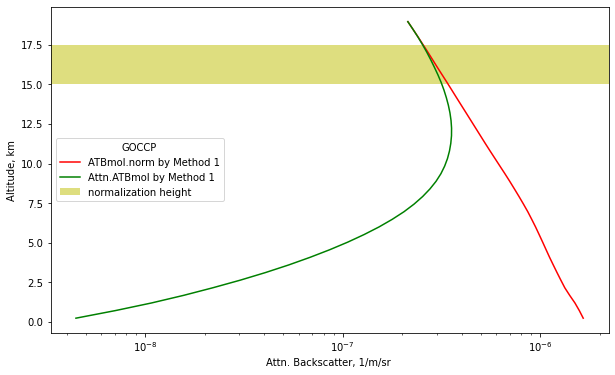

In [211]:
fig, ax = plt.subplots(figsize=[10,6])
#ax.semilogx(go_ATB_mean*1e-3, go['alt_mid'], label='ATB, 1H averahe profile', color='b')
#ax.semilogx(go_ATBmol_mean*1e-3, go['alt_mid'], label='ATBmol, 1H averahe profile', color='k', linestyle='--')
#ax.semilogx(go_ATBmol_syn, go['alt_mid'], label='Attn.ATBmol.norm by Method 1', color='g')
ax.semilogx(go_molbsc, go['alt_mid'], label='ATBmol.norm by Method 1', color='r')
ax.semilogx(B, go['alt_mid'], label='Attn.ATBmol by Method 1', color='g')
#ax.fill_betweenx(go['alt_mid'], go_ATBmol_syn_norm-rmse, go_ATBmol_syn_norm+rmse, 
#                 alpha=0.25, color='g', label='rmse of ATBmol by Method 1')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='normalization height')
leg = ax.legend()
leg.set_title('GOCCP')
ax.set(ylabel='Altitude, km', xlabel='Attn. Backscatter, 1/m/sr ')
#ax.set_xlim(0, 0.5e-5)



#ax2.plot(go_SR_mean, go['alt_mid'], label='GOCCP SR', color='b')
#ax2.plot((go_ATBmol_mean*1e-3)/go_ATBmol_syn_norm, go['alt_mid'], label='SR from ATBmol by Method 1', color='g')

[Text(0.5, 0, 'Scattering Ratio')]

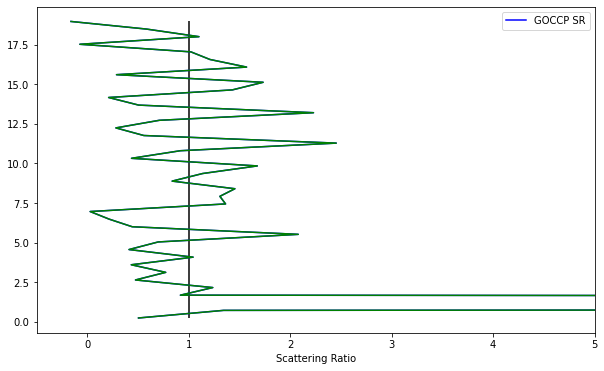

In [53]:
fig2, ax2 = plt.subplots(figsize=[10,6])
ax2.plot(go['instant_SR'].isel(it=1000), go['alt_mid'], label='GOCCP SR', color='b')
ax2.plot(go['ATB'].isel(it=1000)/go['ATB_mol'].isel(it=1000), go['alt_mid'], color='g')
ax2.vlines(1, ymin=go['alt_mid'].values.min(), ymax=go['alt_mid'].values.max(), color='k')
ax2.set_xlim(-0.5, 5)
ax2.legend()
ax2.set(xlabel='Scattering Ratio')

(33,)


[Text(0.5, 0, 'Molecular_Number_Density \nmolecules par m3')]

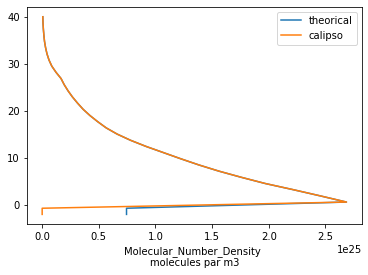

In [177]:
ca_MND = compute_numb_density(P=ca['Pressure'][100,:].values*100, T=ca['Temperature'][100,:].values+273.15)
print(ca_MND.shape)
fig, ax = plt.subplots()
ax.plot(ca_MND, met_alt, label='theorical')
ax.plot(ca['Molecular_Number_Density'][100,:].values, met_alt, label='calipso')
ax.legend()
ax.set(xlabel='Molecular_Number_Density \nmolecules par m3')

[3.21148690e-07 4.35674650e-07 6.26896622e-07 8.93204628e-07
 1.23359030e-06 1.77809329e-06 2.51523898e-06 3.56119131e-06
 5.04409445e-06 7.25631526e-06 9.86981831e-06 1.15303128e-05
 1.35537175e-05 1.58728089e-05 1.85547669e-05 2.14824777e-05
 2.50276971e-05 2.91023171e-05 3.35408076e-05 3.92360198e-05
 4.62389544e-05 5.43967399e-05 6.34896060e-05 7.25760110e-05
 8.20779242e-05 9.25228160e-05 1.04266561e-04 1.16744799e-04
 1.31415320e-04 1.45504120e-04 1.59210380e-04 4.41403317e-05
 4.41403317e-05]
<xarray.DataArray 'Total_Attenuated_Backscatter_532' (fakeDim61: 583)>
array([-9.999000e+03,  2.162090e-06, -1.308388e-06, ...,  5.441879e-05,
        1.972646e-05,  1.777373e-05], dtype=float32)
Dimensions without coordinates: fakeDim61
Attributes:
    units:        per kilometer per steradian
    format:       Float_32
    valid_range:  -0.1...3.3
    fillvalue:    -9999.0


(20.0, 40.0)

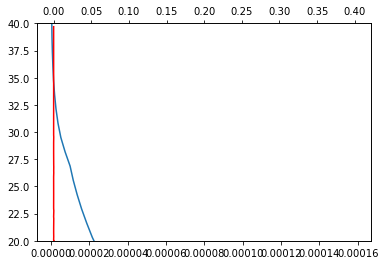

In [90]:
#RayScat532 = computeRayleighScat(532)
#bcsmol532 = computeTotalMolVolBscCoef(ND=ca['Molecular_Number_Density'][100,:], RayScat=RayScat532)

# non calculer Constance de calibration, mais calculer R = ATB/ARB mol 

mol532_Calipso = computeMolATB_Calipso(P=ca['Pressure'][100,:].values, T=ca['Temperature'][100,:].values+273.15)
print(mol532_Calipso[1])
print(ca['Total_Attenuated_Backscatter_532'][100,:])
Attnmol532_Calipso = computeAttnMolATB_Calipso(alt=met_alt, scat_vol, beta_vol)

#attnmol532_Calipso = 
fig, ax = plt.subplots()
ax.plot(mol532_Calipso[1], met_alt)
ax2 = ax.twiny()
ax2.plot(ca['Total_Attenuated_Backscatter_532'][100,1:], alt_range[1:], color='r')
ax.set_ylim(20,40)


7.600506e-07
<xarray.DataArray 'Total_Attenuated_Backscatter_532' ()>
array(1.49896805e-05, dtype=float32)
<xarray.DataArray 'Total_Attenuated_Backscatter_532' ()>
array(19.72195, dtype=float32)


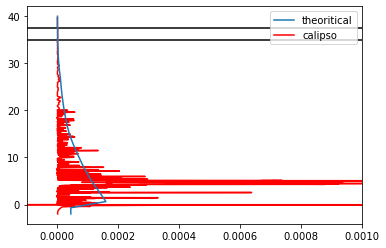

In [180]:
mol532_C = mol532_Calipso[1][((met_alt>=35)&(met_alt<=37.5))].mean()
print(mol532_C)
attn_bsc532_C = ca['Total_Attenuated_Backscatter_532'][100,((alt_range>=35)&(alt_range<=37.5))].mean()
print(attn_bsc532_C)
ConstCal = attn_bsc532_C/mol532_C
print(ConstCal)

fig, ax = plt.subplots()
ax.hlines(35, xmin=-0.0001, xmax=0.001, color='k')
ax.hlines(37.5, xmin=-0.0001, xmax=0.001, color='k')
ax.plot(mol532_Calipso[1], met_alt, zorder=10, label='theoritical')
ax.plot(ca['Total_Attenuated_Backscatter_532'][100,1:]/ConstCal, alt_range[1:], color='r', label='calipso')
ax.set_xlim(-0.0001,0.001)
ax.legend()

In [338]:
#_____test 2nd theoritical method___: alpha(N, P, T, wave)
import math
def compute_numb_density(P,T):
    # P in Pa, T in K
    Na = 6.02e23
    R = 8.31451
    numb_density = (P*Na)/(T*R)
    return numb_density


def computeMolExtinction(P, T, ND):
    DepFactor = 0.0284
    n_s2 = 5.5647e-4+1
    Nso = 2.547e19 #cm-3
    wave = 532e-3
    T0 = 288.15 #K
    P0 = 1013.25 #hPa 
    MolExtinctionConst = (8*(math.pi)**3/(3*wave**4))*((n_s2-1)/Nso)**2*((6+3*DepFactor)/(6-7*DepFactor))*T0/P0
    MolExtinction = MolExtinctionConst*ND*P/T
    return MolExtinction

def computeMolBackscatter(MolExtinction):
    MolBackscatter = MolExtinction/(8*math.pi/3)    
    return MolBackscatter

def computeAttnMolBsc(beta_vol, scat_vol, alt):
    opt_depth = np.zeros_like(scat_vol)
    for i in range(1,(len(alt))):
        opt_depth[i] = opt_depth[i-1]+scat_vol[i]*(alt[i]-alt[i-1])
        
    AttnMolATB = beta_vol * np.exp(-2*opt_depth)
    return AttnMolATB

In [341]:
#_____CALIPSO_____
calipsopath = list(calipsodir.glob('CAL_LID_L1-Standard-V4-10.*ZN.hdf'))
ca = xr.open_dataset(calipsopath[0])

ca_MND = compute_numb_density(P = ca['Pressure'][100,:].values*100, T = ca['Temperature'][100,:].values+273.15)
ca_Ext = computeMolExtinction(P=ca['Pressure'][100,:].values, T=ca['Temperature'][100,:].values+273.15, ND=ca_MND)
ca_BscMol = computeMolBackscatter(ca_Ext)
ca_AttnBscMol = computeAttnMolBsc(ca_BscMol, ca_Ext, met_alt)
print(ca_AttnBscMol)


[7.11476096e-24 1.30940048e-23 2.71106439e-23 5.50363830e-23
 1.04975967e-22 2.18100729e-22 4.36421935e-22 8.74860224e-22
 1.75515084e-21 3.63228861e-21 6.71995148e-21 9.17128345e-21
 1.26725750e-20 1.73802295e-20 2.37497464e-20 3.18358747e-20
 4.32105516e-20 5.84255826e-20 7.76059429e-20 1.06198365e-19
 1.47490478e-19 2.04123825e-19 2.78069455e-19 3.63357541e-19
 4.64729972e-19 5.90535044e-19 7.49959890e-19 9.40206054e-19
 1.19135153e-18 1.46048963e-18 1.74860067e-18 1.34406148e-19
 1.34406148e-19]


(20.0, 40.0)

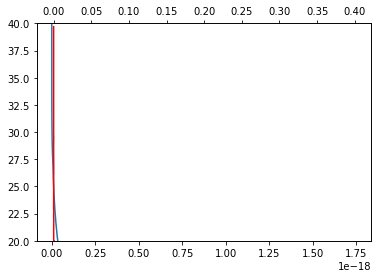

In [346]:
fig, ax = plt.subplots()
#ax.plot(mol532_Calipso[1], met_alt)
ax.plot(ca_AttnBscMol, met_alt)
ax2 = ax.twiny()
ax2.plot(ca['Total_Attenuated_Backscatter_532'][100,1:], alt_range[1:], color='r')
ax.set_ylim(20,40)


4.1073513e-23
<xarray.DataArray 'Total_Attenuated_Backscatter_532' ()>
array(1.49896805e-05, dtype=float32)
<xarray.DataArray 'Total_Attenuated_Backscatter_532' ()>
array(3.649476e+17, dtype=float32)


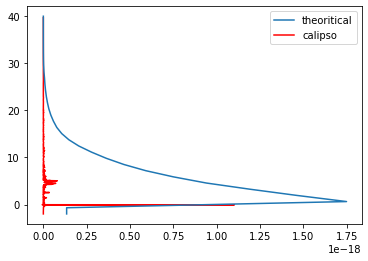

In [347]:
mol532_C = ca_AttnBscMol[((met_alt>=35)&(met_alt<=37.5))].mean()
print(mol532_C)
attn_bsc532_C = ca['Total_Attenuated_Backscatter_532'][100,((alt_range>=35)&(alt_range<=37.5))].mean()
print(attn_bsc532_C)
ConstCal = attn_bsc532_C/mol532_C
print(ConstCal)

fig, ax = plt.subplots()
#ax.hlines(35, xmin=-0.0001, xmax=0.001, color='k')
#ax.hlines(37.5, xmin=-0.0001, xmax=0.001, color='k')
ax.plot(ca_AttnBscMol, met_alt, zorder=10, label='theoritical')
ax.plot(ca['Total_Attenuated_Backscatter_532'][100,1:]/ConstCal, alt_range[1:], color='r', label='calipso')
#ax.set_xlim(-0.0001,0.001)
ax.legend()

## CALIPSO

In [4]:
calipsodir = Path('/bdd/CALIPSO/Lidar_L1/CAL_LID_L1.v4.10/2019/2019_12_11/')#CAL_LID_L1-Standard-V4-10.2016-07-14T01-13-03ZN.hdf')
calipsopath = sorted(calipsodir.glob('CAL_LID_L1-Standard-V4-10.*ZN.hdf'))
print(calipsopath[0])

/bdd/CALIPSO/Lidar_L1/CAL_LID_L1.v4.10/2019/2019_12_11/CAL_LID_L1-Standard-V4-10.2019-12-11T01-26-13ZN.hdf


In [7]:
ca = xr.open_dataset(calipsopath[0])
print(ca.variables)

Frozen({'Profile_Time': <xarray.Variable (fakeDim0: 55680, fakeDim1: 1)>
array([[8.501812e+08],
       [8.501812e+08],
       [8.501812e+08],
       ...,
       [8.501839e+08],
       [8.501839e+08],
       [8.501839e+08]])
Attributes:
    units:        seconds...TAI
    format:       Float_64
    valid_range:  4.204E8...1.072E9, 'Profile_UTC_Time': <xarray.Variable (fakeDim2: 55680, fakeDim3: 1)>
array([[191211.059819],
       [191211.05982 ],
       [191211.05982 ],
       ...,
       [191211.091782],
       [191211.091782],
       [191211.091783]])
Attributes:
    units:        UTC - yymmdd.ffffffff
    format:       Float_64
    valid_range:  60426.0...261231.0, 'Profile_ID': <xarray.Variable (fakeDim4: 55680, fakeDim5: 1)>
array([[104100],
       [104101],
       [104102],
       ...,
       [159777],
       [159778],
       [159779]], dtype=int32)
Attributes:
    format:        Int_32
    valid_range:   1...228,630
    range_values:  profile number from start of file, 'Land_Water

In [9]:
#_______Calculer l'altitude de Calipso selon le guide de l'index______

met_alt = np.linspace(40.0, -2.0, 33)
r_c = (met_alt>=30)&(met_alt>=34)
# Lidar_Data_Altitude
# This field defines the lidar data altitudes (583 range bins) to which lidar Level 1 profile products are registered.
alt_range = np.zeros([583])
alt_range[:33] = np.linspace(40.0, 30.1, len(alt_range[:33]))
alt_range[33:88] = np.linspace(30.1, 20.2, len(alt_range[33:88]))
alt_range[88:288] = np.linspace(20.2, 8.3, len(alt_range[88:288]))
alt_range[288:578] = np.linspace(8.3, -0.5, len(alt_range[288:578]))
alt_range[578:] = np.linspace(-0.5, -2.0, len(alt_range[578:]))

print(met_alt)

[40.     38.6875 37.375  36.0625 34.75   33.4375 32.125  30.8125 29.5
 28.1875 26.875  25.5625 24.25   22.9375 21.625  20.3125 19.     17.6875
 16.375  15.0625 13.75   12.4375 11.125   9.8125  8.5     7.1875  5.875
  4.5625  3.25    1.9375  0.625  -0.6875 -2.    ]


<xarray.DataArray 'Pressure' (fakeDim86: 800, fakeDim87: 33)>
array([[ 1.791633e+00,  2.362846e+00,  3.318635e+00, ...,  1.007435e+03,
        -9.999000e+03, -9.999000e+03],
       [ 1.791632e+00,  2.362844e+00,  3.318633e+00, ...,  1.007435e+03,
        -9.999000e+03, -9.999000e+03],
       [ 1.791631e+00,  2.362843e+00,  3.318630e+00, ...,  1.007435e+03,
        -9.999000e+03, -9.999000e+03],
       ...,
       [ 1.742290e+00,  2.293711e+00,  3.218632e+00, ...,  1.009936e+03,
        -9.999000e+03, -9.999000e+03],
       [ 1.742289e+00,  2.293710e+00,  3.218630e+00, ...,  1.009936e+03,
        -9.999000e+03, -9.999000e+03],
       [ 1.742288e+00,  2.293708e+00,  3.218628e+00, ...,  1.009936e+03,
        -9.999000e+03, -9.999000e+03]], dtype=float32)
Dimensions without coordinates: fakeDim86, fakeDim87
Attributes:
    units:        millibars
    format:       Float_32
    valid_range:  1.0...1,086.0


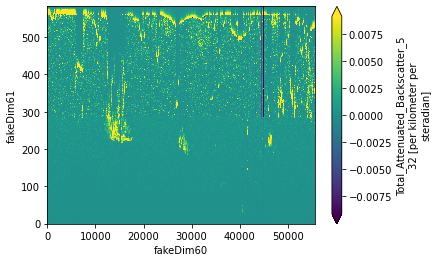

In [43]:
#______Plot QL______
fig, ax = plt.subplots()
ca['Total_Attenuated_Backscatter_532'][1000:3000,:].plot(x='fakeDim60', y='fakeDim61', cmap='viridis', robust=True)


#______Average + plot ATB, ATBmol 
ca_ATB_mean = ca['Total_Attenuated_Backscatter_532'][1000:1800,:].mean(('fakeDim60'))
ca_TEMP_mean = ca['Temperature'][1000:1800,:].mean(('fakeDim84'))
ca_PRES_mean = ca['Pressure'][1000:1800,:].mean(('fakeDim86'))#milibars
ca_MND_mean = ca['Molecular_Number_Density'][1000:1800,:].mean(('fakeDim80'))

print(ca['Pressure'][1000:1800,:])

In [64]:
#_______METHODE 3_________
# ca_extmol, ca_bcsmol  = Method3.computeMolBackscatter(P = ca_PRES_mean.values.astype('float'), 
#                                                 T = ca_TEMP_mean.values.astype('float')+273.15, 
#                                                 w=532)

# ca_ATBmol_syn3 = Method3.computeAttnMolBackscatter(alt = met_alt*1e3, extinction = ca_extmol, beta_vol = ca_bcsmol, datafrom = 'top')

import math
#ca_bcsmol = 5.167e-27*ca_MND_mean*(3/(8*math.pi))
#ca_extmol = ca_bcsmolsmol/0.119
#ca_ATBmol_syn1 = Method3.computeAttnMolBackscatter(alt = met_alt*1e3, extinction = ca_extmol, beta_vol = ca_bcsmol, datafrom = 'top')

#__________
Na = 6.02214e23
Ra = 8.314472
ca_scat = (Na*ca_PRES_mean.values*5.167e-27)/(ca_TEMP_mean.values*Ra)
print(ca_scat.shape)
ca_beta = ca_scat/(8*math.pi*1.0401/3)
tau = np.zeros_like(ca_scat)
for i in range(1,len(met_alt)):
    print((met_alt[i]-met_alt[0])*1e3)
    tau[i] = ca_scat[i]*(met_alt[i]-met_alt[0])*1e3 + ca_scat[0]
    
tau[0] = ca_scat[0]    
print((-2*tau))
ca_attnbeta = ca_beta*np.exp(-2*tau)
ca_Cpar = ca_attnbeta/(1-1/ca_beta)

# print(ca_Cpar)
# print(ca_attnbeta)
# print(ca_scat)
# print(met_alt)
# fig, ax = plt.subplots()
# ax.plot(ca_attnbeta[:30], met_alt[:30], label='attn', color='r')
# ax2 = ax.twiny()
# ax2.plot(ca_beta[:30], met_alt[:30], label='beta')


(33,)
-1312.5
-2625.0
-3937.5
-5250.0
-6562.5
-7875.0
-9187.5
-10500.0
-11812.5
-13125.0
-14437.5
-15750.0
-17062.5
-18375.0
-19687.5
-21000.0
-22312.5
-23625.0
-24937.5
-26250.0
-27562.5
-28875.0
-30187.5
-31500.0
-32812.5
-34125.0
-35437.5
-36750.0
-38062.5
-39375.0
-40687.5
-42000.0
[ 2.7417809e-05 -3.8539398e-02 -9.3960695e-02 -1.8922883e-01
 -3.2927150e-01 -5.6808388e-01 -9.5263153e-01 -1.5881573e+00
 -2.6323078e+00 -4.4481168e+00 -7.0035892e+00 -9.2369576e+00
 -1.2278810e+01 -1.6306482e+01 -2.1479271e+01 -2.7508268e+01
 -3.4952244e+01 -4.3740925e+01 -5.3878452e+01 -6.6818207e+01
 -8.2985939e+01 -1.0475342e+02 -1.4051562e+02 -1.9498795e+02
 -2.7187326e+02 -3.9316635e+02 -5.3863879e+02 -8.5597858e+02
 -1.5084856e+03 -1.6224489e+03 -2.2654298e+02  3.0454119e+01
  3.1436508e+01]


In [40]:
#______Normalisation_______
zbottom = 30
ztop = 34
idx_range = (alt_range>=zbottom) & (alt_range<=ztop)
idx_met = (met_alt>=zbottom) & (met_alt<=ztop)

c1 = np.mean(ca_ATB_mean[idx_range]*1e-3)/np.mean(ca_attnbeta[idx_met])
#print(ca_ATBmol_syn)
print(c1)
ca_attnbeta_norm = ca_attnbeta*c1.values
print(ca_attnbeta_norm)

# c3 = np.mean(ca_ATB_mean[idx_range]*1e-3)/np.mean(ca_ATBmol_syn3[idx_met])
# #print(ca_ATBmol_syn)
# print(c3)
# ca_ATBmol_syn3_norm = ca_ATBmol_syn3*c1.values
# print(ca_ATBmol_syn3_norm)

<xarray.DataArray 'Total_Attenuated_Backscatter_532' ()>
array(-0.00192403, dtype=float32)
[ 3.02714520e-09  3.24413008e-09  3.95278565e-09  5.30576427e-09
  6.92290669e-09  9.55251966e-09  1.33436213e-08  1.90552392e-08
  2.76063652e-08  4.13909831e-08  5.85035131e-08  6.99885803e-08
  8.50245883e-08  1.03809484e-07  1.26317900e-07  1.50081419e-07
  1.77450431e-07  2.07178203e-07  2.38585983e-07  2.76709329e-07
  3.21244357e-07  3.77882174e-07  4.66850707e-07  5.86812007e-07
  7.26078270e-07  8.92868627e-07  1.01694548e-06  1.13306180e-06
  1.00266845e-06  9.29081068e-07  5.06458889e-07 -8.51944222e-08
 -8.52781596e-08]


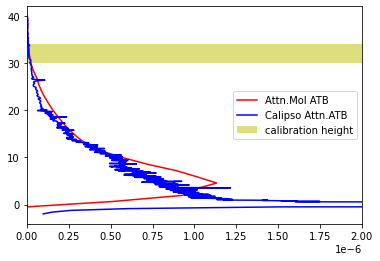

In [41]:
fig, ax = plt.subplots()
ax.semilogx(ca_attnbeta_norm, met_alt, label='Attn.Mol ATB', color='r')
ax.semilogx(ca_ATB_mean*1e-3, alt_range, label='Calipso Attn.ATB', color='b')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.set_xlim(0,2e-6)
ax.legend()
#ax2 = ax.twiny()
#ax2.plot(ca_ATB_mean*1e-3, alt_range, label='Attn.ATB')

In [59]:
ca.variables

Frozen({'Profile_Time': <xarray.Variable (fakeDim0: 55680, fakeDim1: 1)>
array([[8.501812e+08],
       [8.501812e+08],
       [8.501812e+08],
       ...,
       [8.501839e+08],
       [8.501839e+08],
       [8.501839e+08]])
Attributes:
    units:        seconds...TAI
    format:       Float_64
    valid_range:  4.204E8...1.072E9, 'Profile_UTC_Time': <xarray.Variable (fakeDim2: 55680, fakeDim3: 1)>
array([[191211.059819],
       [191211.05982 ],
       [191211.05982 ],
       ...,
       [191211.091782],
       [191211.091782],
       [191211.091783]])
Attributes:
    units:        UTC - yymmdd.ffffffff
    format:       Float_64
    valid_range:  60426.0...261231.0, 'Profile_ID': <xarray.Variable (fakeDim4: 55680, fakeDim5: 1)>
array([[104100],
       [104101],
       [104102],
       ...,
       [159777],
       [159778],
       [159779]], dtype=int32)
Attributes:
    format:        Int_32
    valid_range:   1...228,630
    range_values:  profile number from start of file, 'Land_Water

In [65]:
ca['Total_Attenuated_Backscatter_532'][1000,:]
ca['Perpendicular_Attenuated_Backscatter_532'][1000,:] + ca['Parallel_Attenuated_Backscatter_532'][1000,:]

KeyError: 'Parallel_Attenuated_Backscatter_532'